# Solution: Simulating the effective reproduction number R<sub>eff</sub>

In this example, we have chosen a daily infection rate of 0.4 and a daily recovery rate of 0.1 to get an R<sub>0</sub> of 4. We are modelling this epidemic over the course of about 3 months.

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Vector storing the initial number of people in each compartment (at timestep 0)
initial_state_values <- c(S = 1000000-1,   # the whole population we are modelling is susceptible to infection
                          I = 1,           # the epidemic starts with a single infected person
                          R = 0)           # there is no prior immunity in the population

# Vector storing the parameters describing the transition rates in units of days^-1
parameters <- c(beta = 0.4,      # the infection rate, which acts on susceptibles
                gamma = 0.1)     # the rate of recovery, which acts on those infected

# TIMESTEPS:

# Vector storing the sequence of timesteps to solve the model at
times <- seq(from = 0, to = 100, by = 1)   # from 0 to 100 days in daily intervals

# SIR MODEL FUNCTION: 

# The model function takes as input arguments (in the following order): time, state and parameters
sir_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {  # tell R to unpack variable names from the state and parameters inputs    
        
    # Calculating the total population size N (the sum of the number of people in each compartment)
      N <- S+I+R
      
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N
        
    # The differential equations
      dS <- -lambda * S               # people move out of (-) the S compartment at a rate lambda (force of infection)
      dI <- lambda * S - gamma * I    # people move into (+) the I compartment from S at a rate lambda, 
                                      # and move out of (-) the I compartment at a rate gamma (recovery)
      dR <- gamma * I                 # people move into (+) the R compartment from I at a rate gamma
      
    # Return the number of people in the S, I and R compartments at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR))) 
    })
  
}

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

Warning message:
"package 'deSolve' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


**Generating 2 plots:**

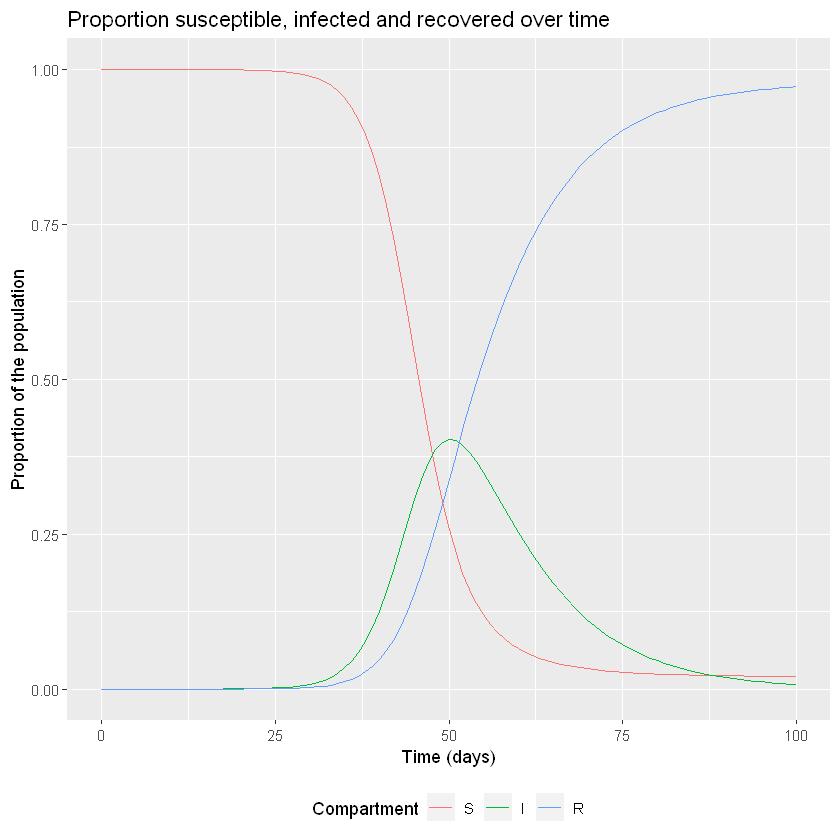

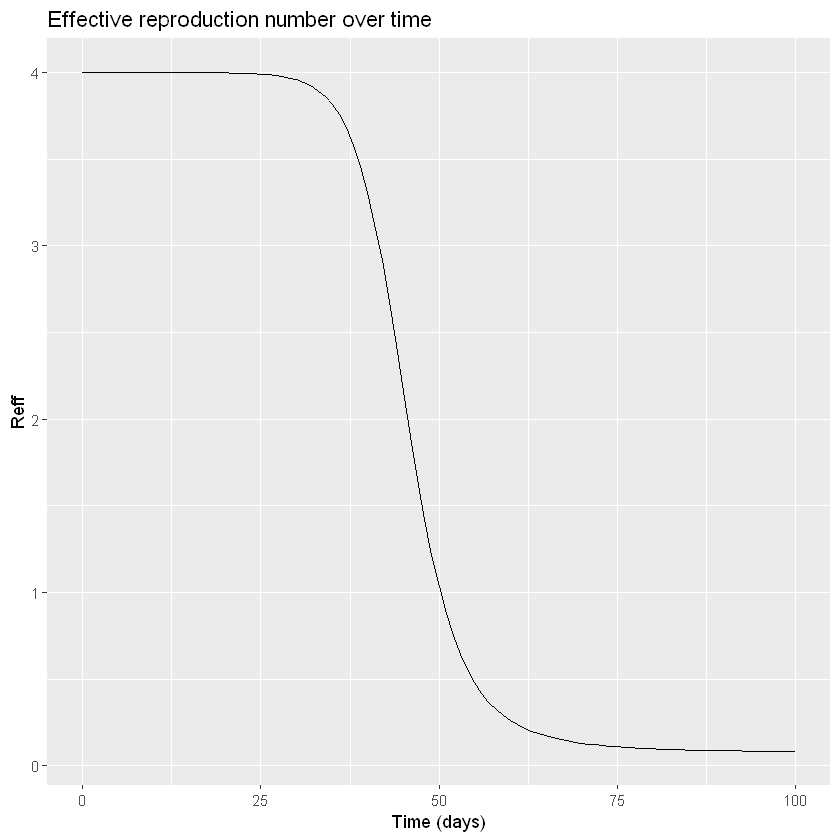

In [2]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Calculating the proportion in each compartment as a column in the long-format output
output_long$proportion <- output_long$value/sum(initial_state_values)

# Plot the proportion of people in the S, I and R compartments over time
ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = proportion, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Proportion of the population") +                                 # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Proportion susceptible, infected and recovered over time") +                                                               
  theme(legend.position = "bottom")                                      # move legend to the bottom of the plot

# Calculating the effective reproduction number in a new column
output$reff <- parameters["beta"]/parameters["gamma"] *                  # R0 = beta/gamma
                output$S/(output$S+output$I+output$R)                    # multiply R0 by the proportion susceptible
                                                                         # at each timestep/for each row
# In this calculation, the total population size (output$S+output$I+output$R) is calculated for each timestep
# so this approach would also be appropriate if the population size varies over time

# Plot Reff
ggplot(data = output,                                                    # specify object containing data to plot
       aes(x = time, y = reff)) +                                        # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Reff") +                                                         # add label for y axis
  labs(title = "Effective reproduction number over time")                # add plot title

### How does R<sub>eff</sub> vary over the course of the epidemic? What do you notice about the connection between the change in R<sub>eff</sub> and the epidemic curve over time? In particular, in relation to R<sub>eff</sub>, when does the epidemic peak and start to decline?

The effective reproduction number is highest when everyone is susceptible: at the beginning, R<sub>eff</sub> = R<sub>0</sub>. At this point in our example, every infected cases causes an average of 4 secondary infections. Over the course of the epidemic, R<sub>eff</sub> declines in proportion to susceptibility. 

The peak of the epidemic happens when R<sub>eff</sub> goes down to 1 (in the example here, after 50 days). As R<sub>eff</sub> decreases further below 1, the epidemic prevalence goes into decline. This is exactly what you would expect, given your understanding of the meaning of R<sub>eff</sub>: once the epidemic reaches the point where every infected case cannot cause at least one more infected case (that is, when R<sub>eff</sub> < 1), the epidemic cannot sustain itself and comes to an end.